In [1]:
import os
os.chdir("dev/")
wav_files=os.listdir("./")

In [2]:
from scipy.io import wavfile
samplerate, _ = wavfile.read("275_9.wav")
samplerate
# will check if is always the same 

8000

# Reading 

In [3]:
import numpy as np
X = [None] * len(wav_files)
dev_y = [None] * len(wav_files)
SR = [None] * len(wav_files)
samp_rate_eq=True # checks if the samplerates are equal
for wav_file in wav_files:
    num, res = wav_file.replace('.wav','').split("_")
    samp_rate, data = wavfile.read(wav_file)
    if(samp_rate!=samplerate):
        samp_rate_eq=False
    num, res= int(num), float(res)
    X[num]=data.astype(np.float32)
    dev_y[num]=res
    SR[num]=samp_rate    

In [4]:
os.chdir('../eval')
wav_files=os.listdir("./")
X_eval = [None] * len(wav_files)
for wav_file in wav_files:
    num= wav_file.replace('.wav','')
    samp_rate, data = wavfile.read(wav_file)
    if(samp_rate!=samplerate):
        samp_rate_eq=False
    num= int(num)
    X_eval[num]=data.astype(np.float32)
    

print(f"the samplerate is always {samplerate}? {samp_rate_eq}")

the samplerate is always 8000? True


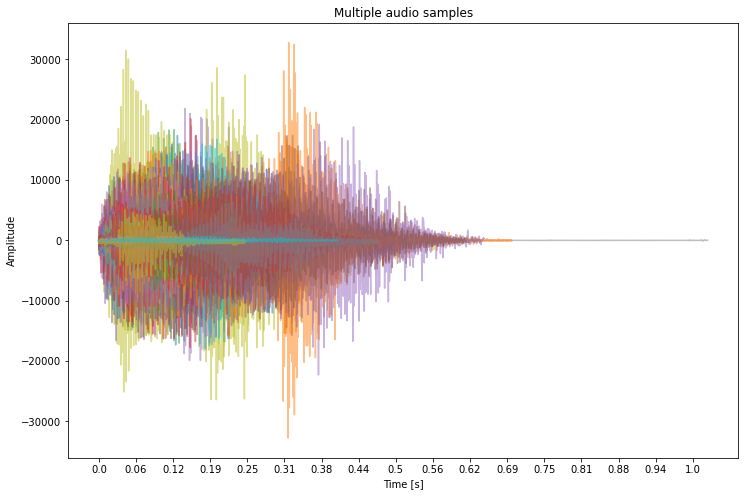

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_audio_samples(X): 
    lengths = []
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    for idx in range(0, len(X), 10): 
        ax.plot(X[idx], alpha=0.5) 
        lengths.append(len(X[idx]))
        
    # To show time on the x axes
    ax.set_xticks(np.arange(0, max(lengths), 500))
    ax.set_xticklabels([round(sample/samplerate,2) for sample in np.arange(0, max(lengths),500)])
    return ax


ax = plot_audio_samples(X)
ax.set_ylabel("Amplitude")
ax.set_xlabel("Time [s]")
ax.set_title("Multiple audio samples")
plt.show()

# Normalization

In [6]:
len(X_eval)

500

In [7]:
from scipy.stats import zscore 

def normalize_data(V):
    return [zscore(x) for x in V]


dev_X = normalize_data(X)
eval_X = normalize_data(X_eval)

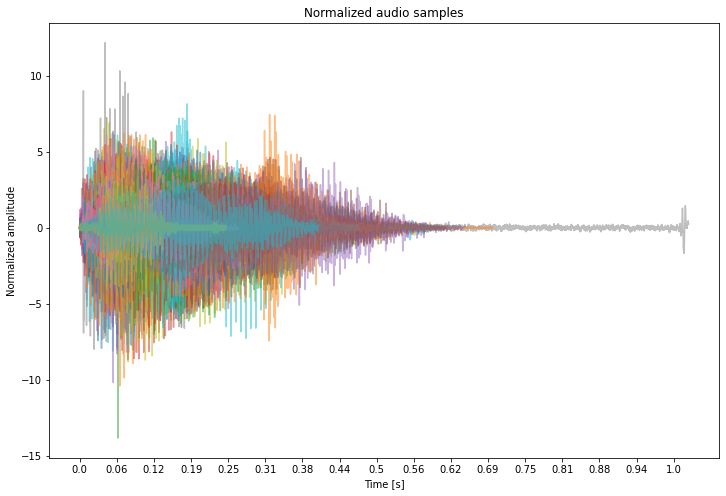

In [8]:
ax = plot_audio_samples(dev_X)
ax.set_ylabel("Normalized amplitude")
ax.set_xlabel("Time [s]")
ax.set_title("Normalized audio samples")
plt.show()

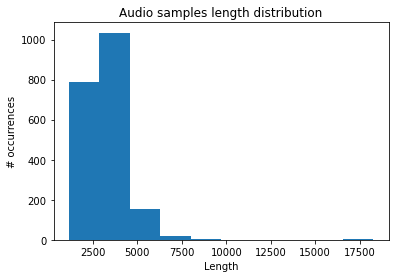

In [9]:
# lenght normalization

dev_lengths = [len(x) for x in dev_X]
eval_lenghts = [len(x) for x in eval_X]
plt.hist(dev_lengths+eval_lenghts)
plt.title("Audio samples length distribution")
plt.xlabel("Length")
plt.ylabel("# occurrences")
plt.show()
plt.close()

In [10]:
perc = 95
# ceil(x) in Python returns a ceiling value of x 
#i.e., the smallest integer greater than or equal to x.
length_95_perc = int(np.ceil(np.percentile(dev_lengths+eval_lenghts, perc))) 

print(f"The {perc}% of the data has length lower or equal to {length_95_perc}.")

The 95% of the data has length lower or equal to 5000.


In [11]:
# APPLY THE CUT 
dev_X = [x[:length_95_perc] for x in dev_X] 
eval_X = [x[:length_95_perc] for x in eval_X]

In [12]:
# ZERO PADDING
# add zeros when the lenght of the vector is below the lenght of the 95-percentile

dev_X = [np.pad(x, (0,length_95_perc-len(x)), constant_values=0.0) for x in dev_X]
eval_X = [np.pad(x, (0,length_95_perc-len(x)), constant_values=0.0) for x in eval_X]

In [13]:
# WINDOW SIZE
# The paper Linguistic uses of segmental duration in English: 
# Acoustic and perceptual evidence highlights that in average 
# unstressed vowels take 70 ms while long consonants such as s 
# can reach a duration of about 200 ms.

# we take in cosideration step of 1/5 of the maximum duration of 200ms

step = int(samplerate * 0.04) # steps of 40 ms
step

320

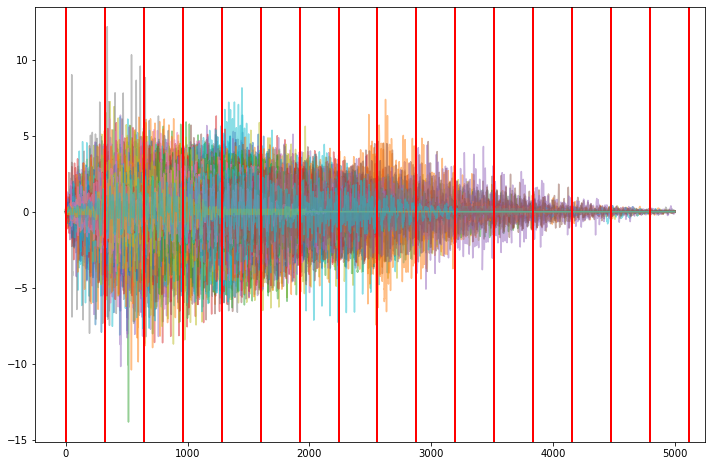

In [14]:
fig, ax = plt.subplots(1,1,figsize=(12,8)) 
for idx in range(0, len(dev_X), 10):
    ax.plot(dev_X[idx], alpha=0.5)
for s in range(0,length_95_perc+step,step): 
    ax.axvline(s, color="red", linewidth=2)
plt.show()
plt.close()

In [15]:
# STATISTICAL FEATURES CALCOLATED IN THE STEP

def RMS(a):
    return np.sqrt(np.mean(np.power(a, 2)))

def compute_signal_statistical_features(x, max_len, step): 
    feat_x = []
    for idx in range(step, max_len+step, step): 
        seg_x = x[idx-step:idx]
        if len(seg_x)>0:
            feat = [np.mean(seg_x),
                    np.std(seg_x),
                    np.min(seg_x),
                    np.max(seg_x),
                      RMS(seg_x)]
        else:
            feat = [0.0, 0.0, 0.0, 0.0, 0.0]
        feat_x.append(np.array(feat))
    return np.nan_to_num(np.hstack(feat_x))

def compute_statistical_features(X, max_len, step): 
    features_X = []
    for x in X:
        f_x = compute_signal_statistical_features(x, max_len, step=step) 
        features_X.append(f_x)
    return np.vstack(features_X)

In [16]:
feat_dev_X = compute_statistical_features(dev_X, length_95_perc, step=step)
feat_dev_X.shape

(1500, 80)

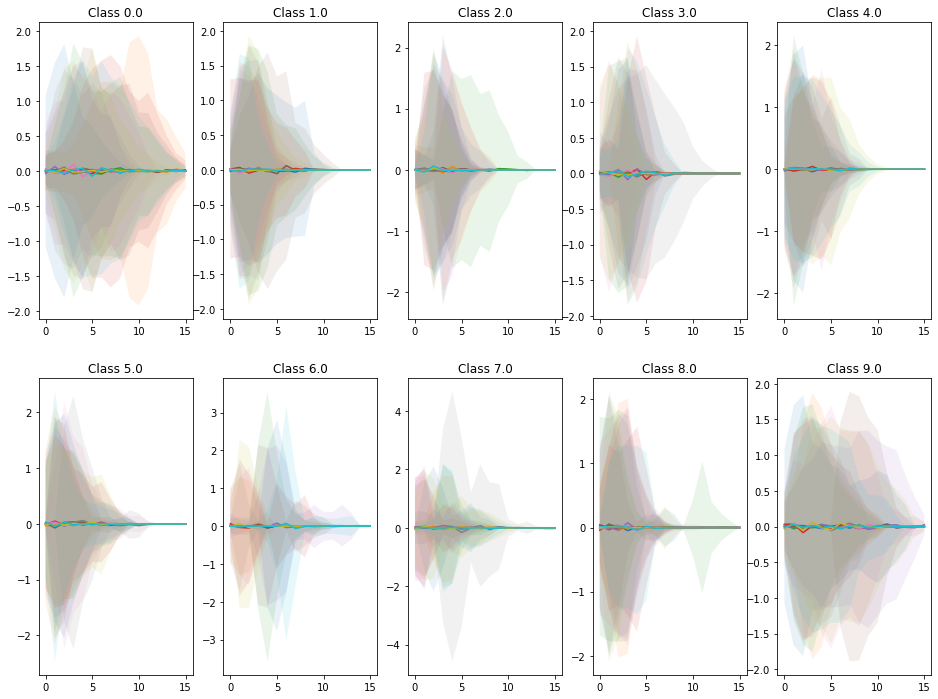

In [17]:
fig, ax = plt.subplots(2,5,figsize=(16,12))
for c in np.unique(dev_y):
    c_feat_dev_X = feat_dev_X[dev_y == c] 
    idx = int(c/5)
    idy = int(c%5)
    
    for i in range(0,10):
        # mean, std, min, max, RMS
        ax[idx, idy].fill_between(x= np.arange(len(c_feat_dev_X[i,0::5])),
                                  y1= c_feat_dev_X[i,0::5]-c_feat_dev_X[i,1::5], # The mean minus the standard deviation
                                  y2=c_feat_dev_X[i,0::5]+c_feat_dev_X[i,1::5], # The mean plus the standard deviation
                                  alpha=0.1)
        ax[idx, idy].plot(c_feat_dev_X[i,0::5]) # The mean values
        ax[idx, idy].set_title(f"Class {c}") 
plt.show()

In [18]:
feat_eval_X = compute_statistical_features(eval_X, length_95_perc, step=step)
feat_eval_X.shape

(500, 80)

# Classification

In [19]:
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier

In [20]:
 # Inspired by SK-learn documentation https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html
def build_classifier(X_train, y_train, X_test, y_test, clf_to_evaluate, scores,param_grid, n_folds=3 ):
    
    print("# Tuning hyper-parameters for %s" % score) 
    print()
    clf = GridSearchCV(clf_to_evaluate, param_grid, cv=n_folds, 
                       scoring=score, verbose=True, n_jobs=4, iid=False)
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" 
              % (mean, std * 2, params))
    print()
    
    print("Detailed classification report:") 
    print()
    print("The model is trained on the full development set.") 
    print("The scores are computed on the full evaluation set.") 
    print()
    y_true, y_pred = y_test, clf.predict(X_test) 
    print(classification_report(y_true, y_pred))
    print()
    return clf

In [21]:
X_train, X_test, y_train, y_test = train_test_split(feat_dev_X, dev_y,test_size=0.4, random_state=0)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((900, 80), (600, 80), 900, 600)

In [23]:
score = 'f1_macro' #score that we want to optimize 
n_estimators = [100, 400, 500, 1000, 2000]
max_depth = [100, 200]
params_grid = {
                'n_estimators': n_estimators,
                'max_depth': max_depth
            }
clf_to_evaluate = RandomForestClassifier()
best_clf = build_classifier(X_train, y_train, X_test, y_test, clf_to_evaluate,score, params_grid)

# Tuning hyper-parameters for f1_macro

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:   14.5s finished
/Users/alessandroferi/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Best parameters set found on development set:

{'max_depth': 200, 'n_estimators': 400}

Grid scores on development set:

0.613 (+/-0.018) for {'max_depth': 100, 'n_estimators': 100}
0.620 (+/-0.027) for {'max_depth': 100, 'n_estimators': 400}
0.625 (+/-0.044) for {'max_depth': 100, 'n_estimators': 500}
0.619 (+/-0.037) for {'max_depth': 100, 'n_estimators': 1000}
0.621 (+/-0.035) for {'max_depth': 100, 'n_estimators': 2000}
0.611 (+/-0.036) for {'max_depth': 200, 'n_estimators': 100}
0.631 (+/-0.026) for {'max_depth': 200, 'n_estimators': 400}
0.627 (+/-0.035) for {'max_depth': 200, 'n_estimators': 500}
0.626 (+/-0.024) for {'max_depth': 200, 'n_estimators': 1000}
0.622 (+/-0.036) for {'max_depth': 200, 'n_estimators': 2000}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.62      0.75      0.68        55
         1.0       

In [24]:
clf = RandomForestClassifier(**best_clf.best_params_)
clf.fit(feat_dev_X, dev_y)

RandomForestClassifier(max_depth=200, n_estimators=400)